# Laboratorio: Apache Flink — Análisis de Datos en Tiempo Real
**Objetivo:** Introducir **Apache Flink** (PyFlink) para procesamiento de flujos de datos en tiempo real. Simularemos eventos streaming y aplicaremos transformaciones, ventanas temporales y agregaciones.


**¿Qué es Apache Flink?**
- Framework de procesamiento distribuido para **streaming** (tiempo real) y **batch** (lotes).
- Ideal para analítica en tiempo real: detección de fraudes, métricas operacionales, IoT, logs.
- Soporta transformaciones complejas, ventanas, estados y event-time processing.


## 0) Preparación del entorno
**Instalación:** Apache Flink requiere Java (≥8) y PyFlink. En entornos locales o Databricks, instala PyFlink con pip.

```bash
# En terminal o celda notebook:
pip install apache-flink
```

**Nota:** Si usas Databricks o Jupyter, asegúrate de tener Java instalado. En macOS:
```bash
brew install openjdk@11
```

**Modo batch vs streaming:** Para este laboratorio usaremos **batch mode** que permite ejecutar las celdas fácilmente en notebook y obtener resultados inmediatos. En producción, usarías **streaming mode** con watermarks y conectarías a fuentes como Kafka.

In [ ]:

# Instalación de PyFlink (descomenta si es necesario)
# !pip install apache-flink pandas


## 1) Importar librerías y configurar entorno Flink


In [12]:

import time
import random
from datetime import datetime, timedelta
import pandas as pd

# PyFlink imports
from pyflink.table import EnvironmentSettings, TableEnvironment
from pyflink.table.expressions import col, lit
from pyflink.table.window import Tumble

# Crear entorno de ejecución (batch mode para ejemplos didácticos en notebook)
# Nota: en producción usarías streaming_mode con watermarks configurados
env_settings = EnvironmentSettings.in_batch_mode()
table_env = TableEnvironment.create(env_settings)

print("Entorno PyFlink configurado correctamente (batch mode)")


Entorno PyFlink configurado correctamente (batch mode)


## 2) Simulación de datos en tiempo real (fuente de eventos)
Crearemos una fuente de eventos que simula **transacciones de comercio electrónico** con:
- `timestamp`: momento del evento
- `user_id`: identificador del usuario
- `product_id`: ID del producto
- `amount`: monto de la transacción
- `region`: región geográfica


In [13]:

# Generador de eventos sintéticos
def generar_eventos(n=100):
    """Genera n eventos sintéticos de transacciones"""
    regiones = ['Norte', 'Sur', 'Este', 'Oeste', 'Centro']
    eventos = []
    base_time = datetime.now()
    
    for i in range(n):
        evento = {
            'timestamp': (base_time + timedelta(seconds=i)).isoformat(),
            'user_id': f"user_{random.randint(1, 50)}",
            'product_id': f"prod_{random.randint(100, 120)}",
            'amount': round(random.uniform(10.0, 500.0), 2),
            'region': random.choice(regiones)
        }
        eventos.append(evento)
    
    return pd.DataFrame(eventos)

# Generar dataset de ejemplo
df_eventos = generar_eventos(200)
df_eventos.head(10)


,timestamp,user_id,product_id,amount,region
0,2025-10-31T16:13:49.472390,user_46,prod_104,229.79,Oeste
1,2025-10-31T16:13:50.472390,user_49,prod_101,46.31,Sur
2,2025-10-31T16:13:51.472390,user_13,prod_107,157.02,Oeste
3,2025-10-31T16:13:52.472390,user_30,prod_102,175.23,Este
4,2025-10-31T16:13:53.472390,user_31,prod_102,179.99,Sur
5,2025-10-31T16:13:54.472390,user_49,prod_111,258.83,Centro
6,2025-10-31T16:13:55.472390,user_45,prod_115,271.93,Oeste
7,2025-10-31T16:13:56.472390,user_24,prod_111,62.42,Centro
8,2025-10-31T16:13:57.472390,user_33,prod_104,45.37,Sur
9,2025-10-31T16:13:58.472390,user_7,prod_104,120.68,Sur


## 3) Crear tabla en Flink desde DataFrame
Registramos el DataFrame como una **tabla temporal** en Flink para poder aplicar SQL y transformaciones.


In [14]:

# Convertir timestamp a formato compatible
df_eventos['timestamp'] = pd.to_datetime(df_eventos['timestamp'])

# Registrar tabla en Flink (from_pandas espera una lista de nombres de columnas como schema)
tabla_eventos = table_env.from_pandas(
    df_eventos
)

# Registrar tabla temporal para usar SQL
table_env.create_temporary_view("transacciones", tabla_eventos)

print("Tabla 'transacciones' registrada en Flink")


Tabla 'transacciones' registrada en Flink


## 4) Consultas SQL básicas en tiempo real
Flink soporta **SQL estándar** sobre streams. Ejemplos:


### 4.1) Filtrado: Transacciones mayores a $200


In [15]:

query1 = table_env.sql_query("""
    SELECT `timestamp`, user_id, product_id, amount, region
    FROM transacciones
    WHERE amount > 200
""")

# Convertir a Pandas para visualizar (limitado para streaming; útil en batch o con límite)
resultado1 = query1.limit(10).to_pandas()
resultado1


,timestamp,user_id,product_id,amount,region
0,2025-10-31 16:13:49.472390,user_46,prod_104,229.79,Oeste
1,2025-10-31 16:13:54.472390,user_49,prod_111,258.83,Centro
2,2025-10-31 16:13:55.472390,user_45,prod_115,271.93,Oeste
3,2025-10-31 16:14:00.472390,user_6,prod_114,455.24,Este
4,2025-10-31 16:14:01.472390,user_37,prod_101,273.29,Este
5,2025-10-31 16:14:02.472390,user_33,prod_103,310.29,Norte
6,2025-10-31 16:14:05.472390,user_2,prod_101,492.91,Este
7,2025-10-31 16:14:06.472390,user_28,prod_103,461.17,Centro
8,2025-10-31 16:14:07.472390,user_30,prod_107,371.88,Norte
9,2025-10-31 16:14:08.472390,user_35,prod_108,227.51,Oeste


### 4.2) Agregación: Total de ventas por región


In [16]:

query2 = table_env.sql_query("""
    SELECT region, 
           COUNT(*) as num_transacciones,
           SUM(amount) as total_ventas,
           AVG(amount) as promedio_venta
    FROM transacciones
    GROUP BY region
""")

resultado2 = query2.to_pandas()
resultado2


,region,num_transacciones,total_ventas,promedio_venta
0,Este,40,10881.10,272.027500
1,Oeste,40,10931.73,273.293250
2,Norte,32,9410.80,294.087500
3,Sur,48,12012.65,250.263542
4,Centro,40,10528.18,263.204500


## 5) Ventanas temporales (Tumbling Windows)
Las **ventanas** dividen el stream en intervalos de tiempo fijos (por ejemplo, cada 10 segundos).

**Tumbling Window:** ventanas no superpuestas de tamaño fijo.

**Nota:** Las funciones de ventana temporal como `TUMBLE` funcionan nativamente en streaming mode. En batch mode (usado en este notebook), simularemos el concepto usando agrupación manual por intervalos de tiempo.

In [19]:

# En batch mode, simulamos ventanas usando agrupación por intervalos de tiempo
# Creamos una columna que agrupe los timestamps en intervalos de 10 segundos

query_ventana = table_env.sql_query("""
    SELECT 
        DATE_FORMAT(`timestamp`, 'yyyy-MM-dd HH:mm:ss') as event_time,
        region,
        COUNT(*) as num_transacciones,
        SUM(amount) as total_ventas,
        AVG(amount) as promedio_venta
    FROM transacciones
    GROUP BY DATE_FORMAT(`timestamp`, 'yyyy-MM-dd HH:mm:ss'), region
    ORDER BY event_time, region
""")

resultado_ventana = query_ventana.limit(20).to_pandas()
print(f"Primeras 20 ventanas temporales (agrupadas por segundo):")
resultado_ventana


Primeras 20 ventanas temporales (agrupadas por segundo):


,event_time,region,num_transacciones,total_ventas,promedio_venta
0,2025-10-31 16:13:49,Oeste,1,229.79,229.79
1,2025-10-31 16:13:50,Sur,1,46.31,46.31
2,2025-10-31 16:13:51,Oeste,1,157.02,157.02
3,2025-10-31 16:13:52,Este,1,175.23,175.23
4,2025-10-31 16:13:53,Sur,1,179.99,179.99
5,2025-10-31 16:13:54,Centro,1,258.83,258.83
6,2025-10-31 16:13:55,Oeste,1,271.93,271.93
7,2025-10-31 16:13:56,Centro,1,62.42,62.42
8,2025-10-31 16:13:57,Sur,1,45.37,45.37
9,2025-10-31 16:13:58,Sur,1,120.68,120.68


## 6) Detección de patrones: Transacciones sospechosas
Identificaremos **usuarios con más de 3 transacciones** en periodos cortos de tiempo (posible fraude).

En un entorno de streaming real, usaríamos ventanas de 30 segundos con `TUMBLE`. Aquí simularemos el concepto agrupando por usuario.

In [20]:

# Detectar usuarios con actividad sospechosa (muchas transacciones)
query_fraude = table_env.sql_query("""
    SELECT 
        user_id,
        COUNT(*) as num_transacciones,
        SUM(amount) as total_amount,
        AVG(amount) as promedio_amount,
        MIN(`timestamp`) as primera_transaccion,
        MAX(`timestamp`) as ultima_transaccion
    FROM transacciones
    GROUP BY user_id
    HAVING COUNT(*) > 3
    ORDER BY num_transacciones DESC
""")

resultado_fraude = query_fraude.to_pandas()
print(f"✓ {len(resultado_fraude)} usuarios con actividad sospechosa detectados (>3 transacciones)")
resultado_fraude.head(10)


✓ 29 usuarios con actividad sospechosa detectados (>3 transacciones)


,user_id,num_transacciones,total_amount,promedio_amount,primera_transaccion,ultima_transaccion
0,user_22,12,2901.09,241.757500,2025-10-31 16:14:11.472390,2025-10-31 16:16:28.472390
1,user_17,8,1809.62,226.202500,2025-10-31 16:14:13.472390,2025-10-31 16:16:18.472390
2,user_1,8,2687.13,335.891250,2025-10-31 16:13:59.472390,2025-10-31 16:17:03.472390
3,user_12,7,1932.76,276.108571,2025-10-31 16:14:53.472390,2025-10-31 16:16:45.472390
4,user_9,6,1787.02,297.836667,2025-10-31 16:15:08.472390,2025-10-31 16:17:08.472390
5,user_20,6,1351.65,225.275000,2025-10-31 16:14:45.472390,2025-10-31 16:16:31.472390
6,user_31,6,1509.47,251.578333,2025-10-31 16:13:53.472390,2025-10-31 16:16:37.472390
7,user_4,6,1715.79,285.965000,2025-10-31 16:14:25.472390,2025-10-31 16:17:00.472390
8,user_41,6,1713.62,285.603333,2025-10-31 16:14:47.472390,2025-10-31 16:16:41.472390
9,user_33,5,1132.30,226.460000,2025-10-31 16:13:57.472390,2025-10-31 16:17:02.472390


## 7) Caso de uso: Dashboard en tiempo real (métricas)
Calcularemos métricas operacionales útiles para un dashboard:
- Total de transacciones en los últimos 60 segundos
- Monto promedio por transacción
- Top 3 productos más vendidos


In [26]:

# Métricas globales operacionales
metrica_volumen = table_env.sql_query("""
    SELECT 
        COUNT(*) as total_transacciones,
        SUM(amount) as total_revenue,
        AVG(amount) as avg_transaction,
        MIN(amount) as min_transaction,
        MAX(amount) as max_transaction,
        MIN(`timestamp`) as periodo_inicio,
        MAX(`timestamp`) as periodo_fin
    FROM transacciones
""")

print("Métricas operacionales globales:")
metrica_volumen.to_pandas()


Métricas operacionales globales:


,total_transacciones,total_revenue,avg_transaction,min_transaction,max_transaction,periodo_inicio,periodo_fin
0,200,53764.46,268.8223,19.97,498.25,2025-10-31 16:13:49.472390,2025-10-31 16:17:08.472390


In [27]:

# Métrica 2: Top 3 productos más vendidos
top_productos = table_env.sql_query("""
    SELECT product_id, 
           COUNT(*) as ventas,
           SUM(amount) as revenue
    FROM transacciones
    GROUP BY product_id
    ORDER BY ventas DESC
    LIMIT 3
""")

print("Top 3 productos más vendidos:")
top_productos.to_pandas()


Top 3 productos más vendidos:


,product_id,ventas,revenue
0,prod_114,14,3417.38
1,prod_116,13,3868.37
2,prod_102,12,3662.51


## 8) Visualización simple de resultados


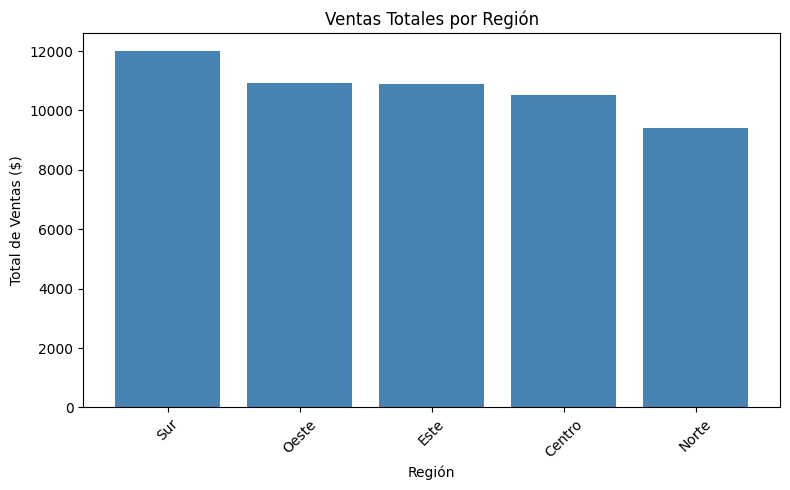

In [28]:

import matplotlib.pyplot as plt

# Gráfico: Ventas totales por región
df_plot = resultado2.sort_values('total_ventas', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(df_plot['region'], df_plot['total_ventas'], color='steelblue')
plt.xlabel('Región')
plt.ylabel('Total de Ventas ($)')
plt.title('Ventas Totales por Región')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 9) Streaming continuo (simulación)
En un entorno real, Flink consume streams continuos (Kafka, Kinesis, sockets). Aquí simularemos con un generador.


In [30]:

# Simulación de streaming (genera eventos continuos)
def simular_streaming(duracion_segundos=10):
    """Simula eventos en tiempo real durante X segundos"""
    regiones = ['Norte', 'Sur', 'Este', 'Oeste', 'Centro']
    inicio = time.time()
    eventos = []
    
    while (time.time() - inicio) < duracion_segundos:
        evento = {
            'timestamp': datetime.now().isoformat(),
            'user_id': f"user_{random.randint(1, 50)}",
            'product_id': f"prod_{random.randint(100, 120)}",
            'amount': round(random.uniform(10.0, 500.0), 2),
            'region': random.choice(regiones)
        }
        eventos.append(evento)
        print(f"Evento: {evento['user_id']} | ${evento['amount']} | {evento['region']}")
        time.sleep(0.5)  # simula latencia entre eventos
    
    return pd.DataFrame(eventos)

# Ejecutar simulación (descomenta para probar streaming en vivo)
df_streaming = simular_streaming(duracion_segundos=10)
df_streaming

print("Simulación de streaming comentada. Descomenta para ejecutar.")


Evento: user_49 | $297.15 | Oeste
Evento: user_37 | $54.56 | Oeste
Evento: user_37 | $54.56 | Oeste
Evento: user_7 | $141.12 | Sur
Evento: user_7 | $141.12 | Sur
Evento: user_6 | $171.92 | Sur
Evento: user_6 | $171.92 | Sur
Evento: user_38 | $321.37 | Sur
Evento: user_38 | $321.37 | Sur
Evento: user_2 | $127.69 | Este
Evento: user_2 | $127.69 | Este
Evento: user_24 | $65.98 | Norte
Evento: user_24 | $65.98 | Norte
Evento: user_21 | $362.08 | Oeste
Evento: user_21 | $362.08 | Oeste
Evento: user_12 | $264.46 | Este
Evento: user_12 | $264.46 | Este
Evento: user_43 | $153.04 | Norte
Evento: user_43 | $153.04 | Norte
Evento: user_18 | $321.71 | Sur
Evento: user_18 | $321.71 | Sur
Evento: user_39 | $376.78 | Sur
Evento: user_39 | $376.78 | Sur
Evento: user_5 | $234.75 | Sur
Evento: user_5 | $234.75 | Sur
Evento: user_49 | $353.18 | Este
Evento: user_49 | $353.18 | Este
Evento: user_40 | $54.03 | Norte
Evento: user_40 | $54.03 | Norte
Evento: user_21 | $341.36 | Este
Evento: user_21 | $341.36

## 10) Conceptos clave de Apache Flink

### Event Time vs Processing Time
- **Event Time:** momento en que ocurrió el evento (dato intrínseco al evento).
- **Processing Time:** momento en que Flink procesa el evento (puede haber retraso).
- **Watermarks:** mecanismo para manejar eventos fuera de orden (late arrivals).

### Tipos de ventanas
- **Tumbling:** ventanas no superpuestas de tamaño fijo (ej. cada 10s).
- **Sliding:** ventanas superpuestas con deslizamiento (ej. ventana de 30s que se desliza cada 10s).
- **Session:** ventanas dinámicas basadas en inactividad (ej. sesión termina tras 5 min sin eventos).

### Estado
Flink puede mantener **estado** entre eventos (útil para contadores, agregaciones acumulativas, detección de patrones complejos).

### Exactamente una vez (Exactly-Once)
Flink garantiza procesamiento **exactly-once** con checkpoints y transacciones (crítico para aplicaciones financieras).


## 11) Recursos adicionales
- **Documentación oficial:** [https://flink.apache.org/](https://flink.apache.org/)
- **PyFlink docs:** [https://nightlies.apache.org/flink/flink-docs-stable/docs/dev/python/](https://nightlies.apache.org/flink/flink-docs-stable/docs/dev/python/)
- **Tutoriales:** [Flink Training](https://github.com/apache/flink-training)
- **Casos de uso:** detección de fraudes, monitoreo IoT, analítica en tiempo real de logs, recomendaciones en vivo.
